<a href="https://colab.research.google.com/github/alf-faren/DS-Unit-2-Linear-Models/blob/master/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

###Exploration and cleaning data

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [9]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [10]:
df['Chips'] = df['Chips'].replace('Yes','x')
df['Chips'] = df['Chips'].replace('No',np.nan)

In [11]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [12]:
ingredients = ['Chips','Unreliable','NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
               'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
                'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
                'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
                'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster',
                'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
                'Corn', 'Zucchini',]

for ingredient in ingredients:
    df[ingredient].replace('X','x')

 ### Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [13]:
# Correcting the typo
df['Date'] = df['Date'].str.replace('2026','2016')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [14]:
cut1 = pd.to_datetime('2017-01-01')
cut2 = pd.to_datetime('2018-01-01')

train = df[df.Date < cut1]
val = df[((df.Date >= cut1) & (df.Date < cut2))]
test = df[df.Date >= cut2]

In [15]:
train.shape, val.shape, test.shape

((299, 59), (85, 59), (37, 59))

### Begin with baselines for classification.

In [16]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.588629
True     0.411371
Name: Great, dtype: float64

In [17]:
maj_class = y_train.mode()[0]
y_pred = [maj_class] * len(y_train)

accuracy_score(y_train, y_pred)

0.5886287625418061

In [18]:
y_val = val[target]
y_pred = [maj_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

### Use scikit-learn for logistic regression.
### Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [19]:
log_reg = LogisticRegression(solver='lbfgs')

In [22]:
features = ['Fillings','Hunger','Synergy', 'Meat', 'Tortilla', 'Salsa']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [23]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((299, 6), (299,), (85, 6), (85,), (37, 6), (37,))

In [24]:
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [25]:
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy :', (log_reg.score(X_val_imputed, y_val) * 100),'%')

Validation Accuracy : 87.05882352941177 %


In [26]:
train['Salsa'].describe()

count    279.000000
mean       3.323477
std        0.969673
min        0.000000
25%        2.500000
50%        3.500000
75%        4.000000
max        5.000000
Name: Salsa, dtype: float64

In [27]:
test1 = [[2, 2, 2, 2, 2, 2]] 
log_reg.predict_proba(test1)

array([[9.99889898e-01, 1.10102161e-04]])

In [28]:
test2 = [[4, 4, 4, 4, 4, 4]]
log_reg.predict_proba(test2)

array([[0.18770068, 0.81229932]])

In [37]:
test3 = [[6, 6, 6, 6, 6, 6]]
log_reg.predict_proba(test3)

array([[5.87950288e-06, 9.99994120e-01]])

In [38]:
features = ['Fillings','Hunger','Synergy', 'Meat', 'Tortilla', 'Salsa']

target = 'Great'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [42]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((299, 6), (299,), (85, 6), (85,))

In [31]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [39]:
model = LogisticRegressionCV(cv=5, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', (model.score(X_val_scaled, y_val) * 100), '%')

Validation Accuracy 87.05882352941177 %


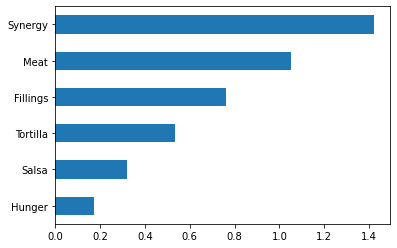

In [40]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

### Get your model's test accuracy. (One time, at the end.)

In [41]:
X_test = test[features]
y_test = test[target]

X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print('Test Accuracy', (model.score(X_test_scaled, y_test) * 100),'%')

Test Accuracy 75.67567567567568 %
